In [16]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy import fftpack
import requests
from io import BytesIO

In [17]:

# Read the image
image = cv2.imread("/content/original_img.jpeg")

# Convert to grayscale manually (OpenCV uses BGR)
grey_img = (0.299 * image[:, :, 2] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 0]).astype(np.uint8)

# Invert the grayscale image
inverted_img = 255 - grey_img

In [18]:
# Generate Gaussian kernel
def get_gaussian_kernel(ksize, sigma):
    ax = np.linspace(-(ksize // 2), ksize // 2, ksize)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

In [19]:
# Apply Gaussian blur
def apply_gaussian_blur(image, ksize=21, sigma=5):
    kernel = get_gaussian_kernel(ksize, sigma)
    # Pad image to avoid border issues
    pad = ksize // 2
    padded_img = np.pad(image, pad, mode='reflect')
    blurred = np.zeros_like(image, dtype=np.float32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_img[i:i+ksize, j:j+ksize]
            blurred[i, j] = np.sum(region * kernel)

    return blurred.astype(np.uint8)

blurred = apply_gaussian_blur(inverted_img, ksize=21, sigma=5)

In [8]:
# Invert the blurred image
inverted_blur = 255 - blurred

# Create pencil sketch using manual divide
sketch = np.clip((grey_img.astype(np.float32) / inverted_blur.astype(np.float32)) * 256, 0, 255)
sketch = sketch.astype(np.uint8)

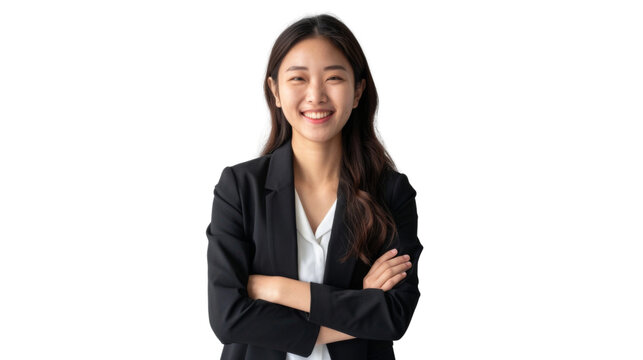

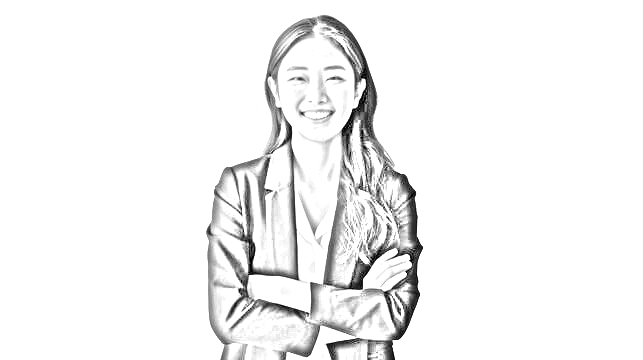

In [9]:
cv2.imwrite("sketch.jpg", sketch)
cv2.imwrite("sketch.png", sketch)

# Display the original and sketch images
cv2_imshow(image)
cv2_imshow(sketch)

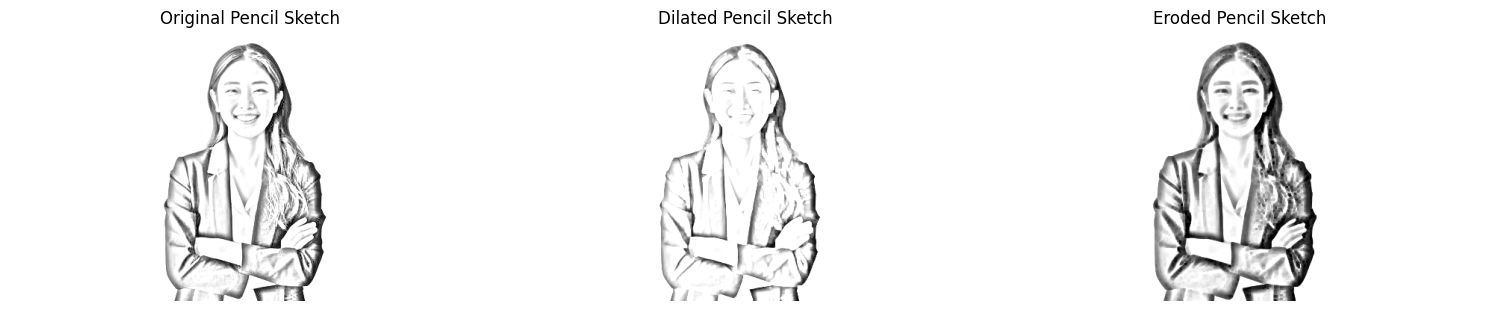

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a 3x3 structuring element
kernel = np.ones((3, 3), np.uint8)

# Apply dilation to the pencil sketch
dilated_sketch = cv2.dilate(sketch, kernel, iterations=1)

# Apply erosion to the pencil sketch
eroded_sketch = cv2.erode(sketch, kernel, iterations=1)

# Display the original, dilated, and eroded sketches
plt.figure(figsize=(15, 5))

# Original sketch
plt.subplot(1, 3, 1)
plt.imshow(sketch, cmap='gray')
plt.title('Original Pencil Sketch')
plt.axis('off')

# Dilated sketch
plt.subplot(1, 3, 2)
plt.imshow(dilated_sketch, cmap='gray')
plt.title('Dilated Pencil Sketch')
plt.axis('off')

# Eroded sketch
plt.subplot(1, 3, 3)
plt.imshow(eroded_sketch, cmap='gray')
plt.title('Eroded Pencil Sketch')
plt.axis('off')

plt.tight_layout()
plt.show()

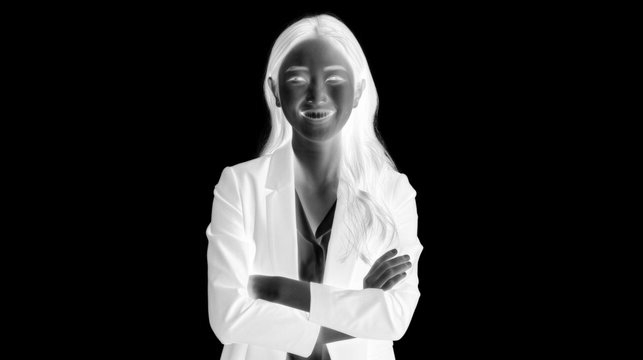

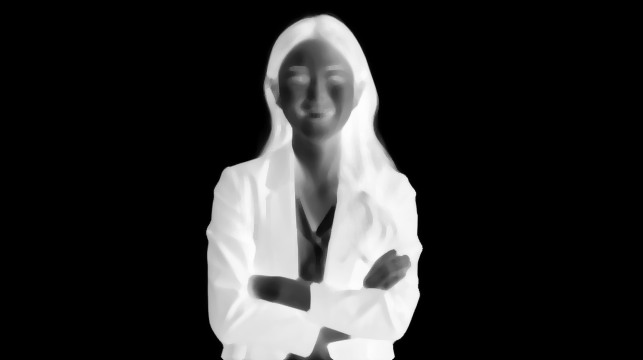

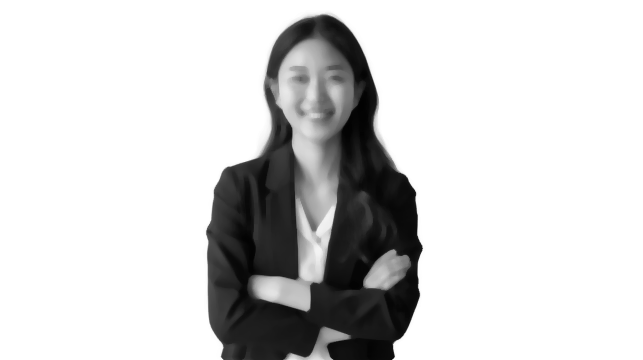

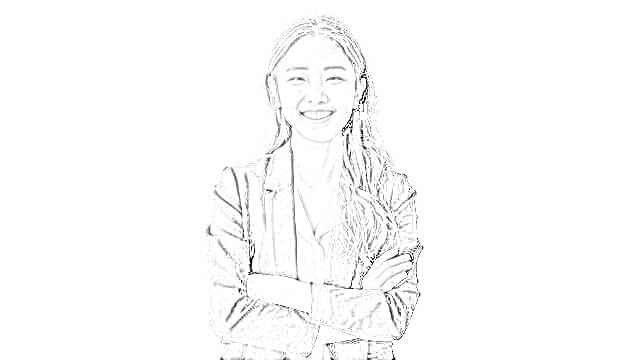

In [21]:
# Define the median filter function
def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = np.zeros_like(data, dtype=np.uint8)  # Match input dtype
    rows, cols = data.shape

    for i in range(rows):
        for j in range(cols):
            # Collect pixel values in the filter_size x filter_size window
            for z in range(filter_size):
                row_idx = i + z - indexer
                # Skip if row index is out of bounds (use zero padding)
                if row_idx < 0 or row_idx >= rows:
                    for c in range(filter_size):
                        temp.append(0)
                    continue
                for k in range(filter_size):
                    col_idx = j + k - indexer
                    # Use zero if column index is out of bounds, else get pixel
                    if col_idx < 0 or col_idx >= cols:
                        temp.append(0)
                    else:
                        temp.append(data[row_idx][col_idx])

            # Sort and pick median
            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []  # Clear for next pixel

    return data_final

cv2_imshow(inverted_img)

# Apply median filter instead of Gaussian blur
filter_size = 7  # Choose an odd number, e.g., 5, 7, or 9; larger sizes are slower
blur_img = median_filter(inverted_img, filter_size)
cv2_imshow(blur_img)

# Invert the blurred image
inv_blur = 255 - blur_img
cv2_imshow(inv_blur)

# Create the pencil sketch by dividing the grayscale by the inverted blurred image
sketch_img = cv2.divide(grey_img, inv_blur, scale=255.0)
cv2_imshow(sketch_img)

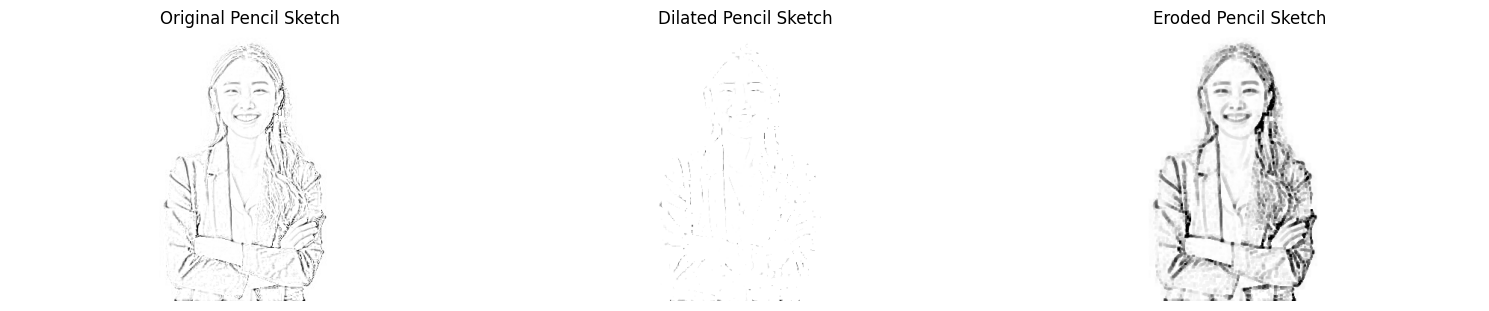

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a 3x3 structuring element
kernel = np.ones((3, 3), np.uint8)

# Apply dilation to the pencil sketch
dilated_sketch = cv2.dilate(sketch_img, kernel, iterations=1)

# Apply erosion to the pencil sketch
eroded_sketch = cv2.erode(sketch_img, kernel, iterations=1)

# Display the original, dilated, and eroded sketches
plt.figure(figsize=(15, 5))

# Original sketch
plt.subplot(1, 3, 1)
plt.imshow(sketch_img, cmap='gray')
plt.title('Original Pencil Sketch')
plt.axis('off')

# Dilated sketch
plt.subplot(1, 3, 2)
plt.imshow(dilated_sketch, cmap='gray')
plt.title('Dilated Pencil Sketch')
plt.axis('off')

# Eroded sketch
plt.subplot(1, 3, 3)
plt.imshow(eroded_sketch, cmap='gray')
plt.title('Eroded Pencil Sketch')
plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
# generating filter
def generate_bilateral_weights(region, center_value, sigma_color, sigma_space):
    diameter = region.shape[0] # size
    half_d = diameter // 2 # distance

    spatial_weights = np.zeros_like(region, dtype=np.float64)
    for x in range(diameter):
        for y in range(diameter):
            dx, dy = x - half_d, y - half_d
            spatial_weights[x, y] = np.exp(-(dx**2 + dy**2) / (2 * sigma_space**2))

    color_diff = region - center_value
    color_weights = np.exp(-(color_diff**2) / (2 * sigma_color**2))

    combined_weights = spatial_weights * color_weights
    combined_weights /= combined_weights.sum()

    return combined_weights


In [24]:
def bilateral_filter(image, diameter=5, sigma_color=12.0, sigma_space=16.0):
    padded_image = np.pad(image, diameter // 2, mode='reflect')
    filtered_image = np.zeros_like(image, dtype=np.float64)

    height, width = image.shape
    half_d = diameter // 2

    for i in range(height):
        for j in range(width):
            i1, j1 = i + half_d, j + half_d
            region = padded_image[i1 - half_d:i1 + half_d + 1, j1 - half_d:j1 + half_d + 1]
            center = padded_image[i1, j1]
            weights = generate_bilateral_weights(region, center, sigma_color, sigma_space)
            filtered_image[i, j] = np.sum(region * weights)

    return filtered_image.astype(np.uint8)

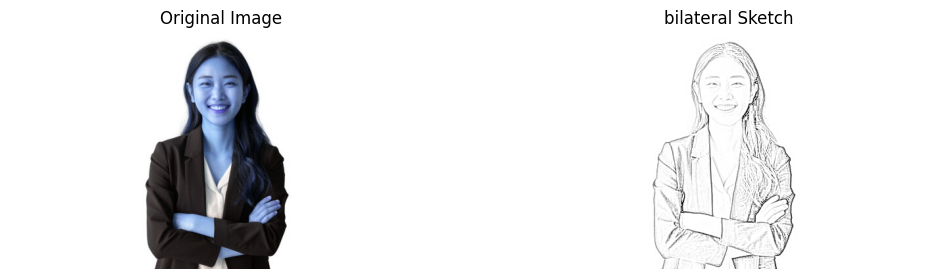

<Figure size 640x480 with 0 Axes>

In [26]:
# Apply bilateral filter to the inverted image
filtered = bilateral_filter(inverted_img, diameter=5, sigma_color=12.0, sigma_space=16.0)

# Invert the blurred image
inverted_blur = 255 - filtered

# Dodge blend
b_sketch = cv2.divide(grey_img, inverted_blur, scale=256.0)

# Displaying result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(b_sketch, cmap='gray')
plt.title("bilateral Sketch")
plt.axis('off')
plt.show()

plt.tight_layout()
plt.show()

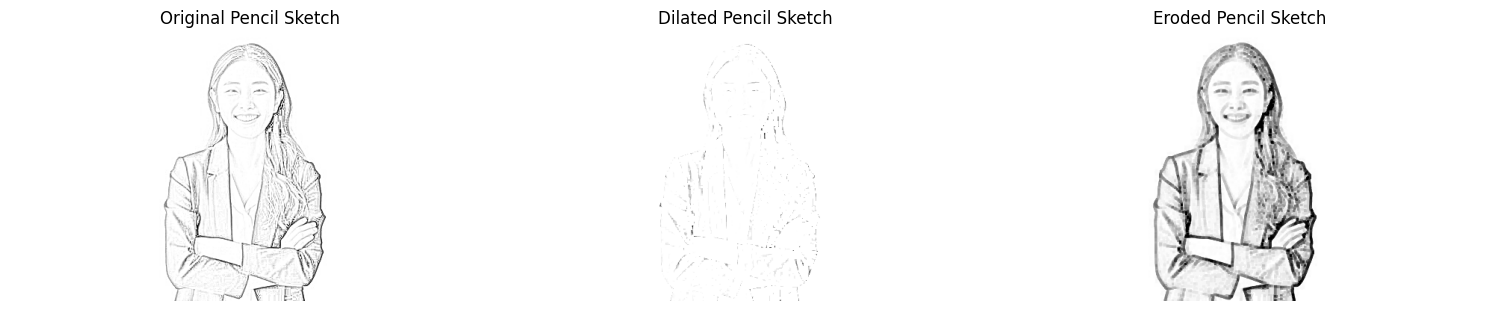

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a 3x3 structuring element
kernel = np.ones((3, 3), np.uint8)

# Apply dilation to the pencil sketch
dilated_sketch = cv2.dilate(b_sketch, kernel, iterations=1)

# Apply erosion to the pencil sketch
eroded_sketch = cv2.erode(b_sketch, kernel, iterations=1)

# Display the original, dilated, and eroded sketches
plt.figure(figsize=(15, 5))

# Original sketch
plt.subplot(1, 3, 1)
plt.imshow(b_sketch, cmap='gray')
plt.title('Original Pencil Sketch')
plt.axis('off')

# Dilated sketch
plt.subplot(1, 3, 2)
plt.imshow(dilated_sketch, cmap='gray')
plt.title('Dilated Pencil Sketch')
plt.axis('off')

# Eroded sketch
plt.subplot(1, 3, 3)
plt.imshow(eroded_sketch, cmap='gray')
plt.title('Eroded Pencil Sketch')
plt.axis('off')

plt.tight_layout()
plt.show()

Compute metrics
PSNR (Peak Signal-to-Noise Ratio)

In [35]:
from skimage.metrics import peak_signal_noise_ratio as psnr , structural_similarity as ssim

reference_image = grey_img
processed_image = sketch

psnr_val = psnr(reference_image, processed_image, data_range=255)
ssim_val = ssim(reference_image, processed_image, data_range=255, multichannel=True)

print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")


PSNR: 10.92 dB
SSIM: 0.8290


. PSNR (Peak Signal-to-Noise Ratio) :
Measures: How much noise (difference) is between two images.

Unit: Decibels (dB)

Higher = Better (means less error between images)

| PSNR Value   | Quality Level                |
| ------------ | ---------------------------- |
| **> 40 dB**  | Excellent (almost identical) |
| **30–40 dB** | Good                         |
| **20–30 dB** | Moderate                     |
| **< 20 dB**  | Poor                         |


 What Do PSNR and SSIM Measure?


What Do PSNR and SSIM Measure?

 | Metric   | Stands For                  | Measures                                           | Typical Range                   | Meaning                                                                                    |
| -------- | --------------------------- | -------------------------------------------------- | ------------------------------- | ------------------------------------------------------------------------------------------ |
| **PSNR** | Peak Signal-to-Noise Ratio  | Pixel-level difference (in decibels)               | 0 to ∞ (higher is better)       | How similar two images are at the pixel level. Sensitive to noise, blur, etc.              |
| **SSIM** | Structural Similarity Index | Structural similarity (luminance, contrast, edges) | -1 to 1 (closer to 1 is better) | How similar two images are in terms of **structure and perception**. Human vision aligned. |


 Compute PSNR and SSIM: for each filter aginest the original image

In [41]:
results = []

for name, processed_image in {
    "Bilateral Sketch": b_sketch,
    "Dilated Sketch": dilated_sketch,
    "Eroded Sketch": eroded_sketch,
    "Median Sketch": sketch_img
}.items():
    psnr_val = psnr(grey_img, processed_image, data_range=255)
    ssim_val = ssim(grey_img, processed_image, data_range=255)
    results.append({"Filter": name, "PSNR (dB)": psnr_val, "SSIM": ssim_val})

# Show results
import pandas as pd
df = pd.DataFrame(results)
print(df.to_string(index=False))



          Filter  PSNR (dB)     SSIM
Bilateral Sketch   9.528708 0.814874
  Dilated Sketch   8.561162 0.783819
   Eroded Sketch  10.626206 0.813584
   Median Sketch   9.241949 0.805738


In [42]:
results = []

for name, processed_image in {
    "Bilateral Sketch": b_sketch,
    "Dilated Sketch": dilated_sketch,
    "Eroded Sketch": eroded_sketch,
    "Median Sketch": sketch_img,
    "Gaussian Sketch": sketch  # Added Gaussian filter here
}.items():
    psnr_val = psnr(grey_img, processed_image, data_range=255)
    ssim_val = ssim(grey_img, processed_image, data_range=255)
    results.append({"Filter": name, "PSNR (dB)": psnr_val, "SSIM": ssim_val})

# Show results
import pandas as pd
df = pd.DataFrame(results)
print(df.to_string(index=False))


          Filter  PSNR (dB)     SSIM
Bilateral Sketch   9.528708 0.814874
  Dilated Sketch   8.561162 0.783819
   Eroded Sketch  10.626206 0.813584
   Median Sketch   9.241949 0.805738
 Gaussian Sketch  10.924323 0.829015


Analyzing the PSNR and SSIM values

PSNR (Peak Signal-to-Noise Ratio) – this measures how close in pixel values the processed image is to the original (higher = better).



SSIM (Structural Similarity Index) – how structurally similar the image is to the original in terms of contrast, luminance, and texture (1 = identical, 0 = completely different, negative = badly distorted).

Gaussian Sketch: 10.92 	PSNR (dB) 0.829 SSIM Best overall: Highest PSNR and SSIM. The Gaussian filter smooths noise effectively while preserving both pixel accuracy and image structure. Ideal for balanced denoising

Eroded Sketch	: 10.63 PSNR (dB) 0.829 SSIM Strong performance: High PSNR and good SSIM. Sharpens edges slightly while preserving structure well. Might add some edge refinement.

Bilateral Sketch: 9.53 PSNR (dB)	0.815	SSIM Strong structure: Slightly lower PSNR but good SSIM. Maintains edges while smoothing textures — great for visual sharpness with noise reduction.

Median Sketch	: 9.24 PSNR (dB) 0.806	Balanced: Moderate PSNR and SSIM. Good at noise removal but tends to slightly blur fine details.

Dilated Sketch	: 8.56 PSNR (dB)	 0.784 SSIM	Weakest: Lowest PSNR and SSIM. Dilation thickens edges and reduces fine detail accuracy, causing structural distortion and loss of clarity.

**SUMMARY OF INTERPRETATION**

The Gaussian Sketch filter performs best overall with the highest PSNR and SSIM, meaning it balances noise smoothing and structural preservation very effectively.


The Eroded Sketch is a close second, sharpening edges while maintaining a strong resemblance to the original image.


The Bilateral Sketch also shows strong structural preservation with very good SSIM, excelling in edge-aware smoothing.


The Median Sketch is effective at noise removal but causes some blurring, reducing fine detail clarity.


The Dilated Sketch is least effective for this task, lowering both pixel-level similarity and structural integrity.

In [43]:
import cv2
import numpy as np
import time

# Load grayscale image
img = cv2.imread('/content/original_img.jpeg', cv2.IMREAD_GRAYSCALE)

# Kernel size
k = 5

# Define helper to measure execution time
def time_filter(name, func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    print(f"{name}: {end - start:.4f} seconds")
    return result

# Gaussian Blur
gaussian_img = time_filter(
    "Gaussian Blur",
    cv2.GaussianBlur, img, (k, k), 0
)

# Median Blur
median_img = time_filter(
    "Median Filter",
    cv2.medianBlur, img, k
)

# Dilation
kernel = np.ones((k, k), np.uint8)
dilated_img = time_filter(
    "Dilation",
    cv2.dilate, img, kernel, iterations=1
)

# Erosion
eroded_img = time_filter(
    "Erosion",
    cv2.erode, img, kernel, iterations=1
)

# Bilateral Filter
bilateral_img = time_filter(
    "Bilateral Filter",
    cv2.bilateralFilter, img, d=9, sigmaColor=75, sigmaSpace=75
)


Gaussian Blur: 0.0005 seconds
Median Filter: 0.0069 seconds
Dilation: 0.0003 seconds
Erosion: 0.0002 seconds
Bilateral Filter: 0.0199 seconds


Visualizing execution times, and PSNR/SSIM values:

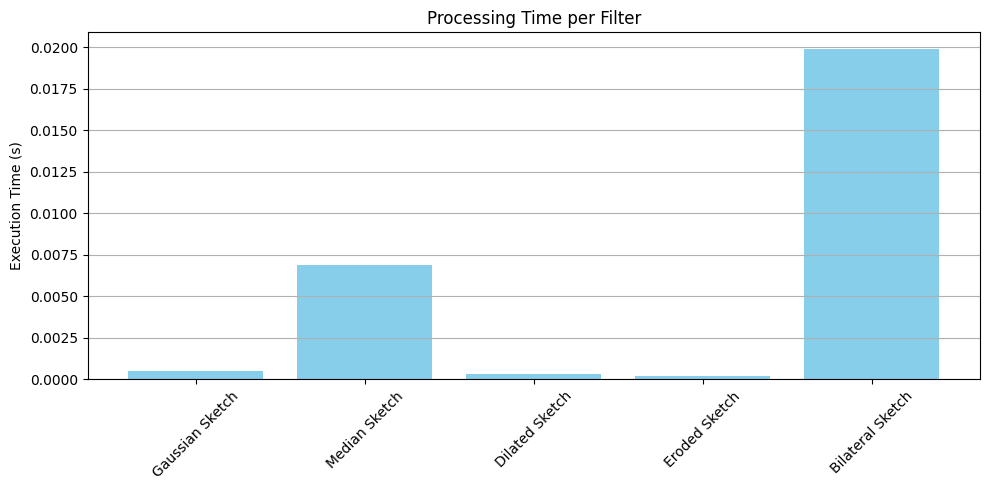

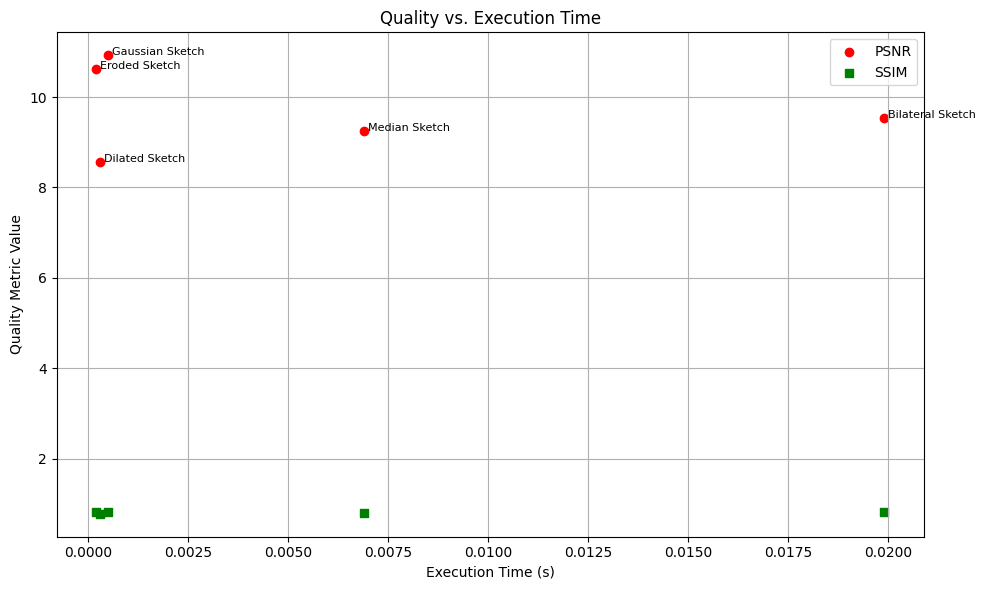

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Data (updated)
filters = [
    "Gaussian Sketch",
    "Median Sketch",
    "Dilated Sketch",
    "Eroded Sketch",
    "Bilateral Sketch"
]

execution_times = [
    0.0005,  # Gaussian
    0.0069,  # Median
    0.0003,  # Dilated
    0.0002,  # Eroded
    0.0199   # Bilateral
]

psnr_values = [
    10.924323,  # Gaussian
    9.241949,   # Median
    8.561162,   # Dilated
    10.626206,  # Eroded
    9.528708    # Bilateral
]

ssim_values = [
    0.829015,  # Gaussian
    0.805738,  # Median
    0.783819,  # Dilated
    0.813584,  # Eroded
    0.814874   # Bilateral
]

# Step 2: Create DataFrame
df = pd.DataFrame({
    "Filter": filters,
    "Execution Time (s)": execution_times,
    "PSNR (dB)": psnr_values,
    "SSIM": ssim_values
})

# Step 3: Bar Plot – Execution Time
plt.figure(figsize=(10, 5))
plt.bar(df["Filter"], df["Execution Time (s)"], color="skyblue")
plt.title("Processing Time per Filter")
plt.ylabel("Execution Time (s)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Step 4: Scatter Plot – PSNR/SSIM vs. Time
plt.figure(figsize=(10, 6))
plt.scatter(df["Execution Time (s)"], df["PSNR (dB)"], label="PSNR", color="red", marker="o")
plt.scatter(df["Execution Time (s)"], df["SSIM"], label="SSIM", color="green", marker="s")
for i, row in df.iterrows():
    plt.text(row["Execution Time (s)"] + 0.0001, row["PSNR (dB)"], row["Filter"], fontsize=8)
plt.xlabel("Execution Time (s)")
plt.ylabel("Quality Metric Value")
plt.title("Quality vs. Execution Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
# Step 5: Export to CSV
df.to_csv("filter_quality_report.csv", index=False)
print("CSV exported as 'filter_quality_report.csv'")


CSV exported as 'filter_quality_report.csv'


In [46]:
from google.colab import files
files.download("filter_quality_report.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>